In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weights/model_weights.h5
/kaggle/input/brain-tumor/2/1231.png
/kaggle/input/brain-tumor/2/641.png
/kaggle/input/brain-tumor/2/1088.png
/kaggle/input/brain-tumor/2/173.png
/kaggle/input/brain-tumor/2/1958.png
/kaggle/input/brain-tumor/2/815.png
/kaggle/input/brain-tumor/2/491.png
/kaggle/input/brain-tumor/2/1924.png
/kaggle/input/brain-tumor/2/1084.png
/kaggle/input/brain-tumor/2/718.png
/kaggle/input/brain-tumor/2/709.png
/kaggle/input/brain-tumor/2/889.png
/kaggle/input/brain-tumor/2/379.png
/kaggle/input/brain-tumor/2/780.png
/kaggle/input/brain-tumor/2/248.png
/kaggle/input/brain-tumor/2/94.png
/kaggle/input/brain-tumor/2/480.png
/kaggle/input/brain-tumor/2/1145.png
/kaggle/input/brain-tumor/2/1944.png
/kaggle/input/brain-tumor/2/236.png
/kaggle/input/brain-tumor/2/1343.png
/kaggle/input/brain-tumor/2/771.png
/kaggle/input/brain-tumor/2/675.png
/kaggle/input/brain-tumor/2/340.png
/kaggle/input/brain-tumor/2/48.png
/kaggle/input/brain-tumor/2/1948.png
/kaggle/input/brai

# Importing the Libraries

In [2]:
import os
import time
import shutil
import pathlib
import itertools


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading the data and getting first impressions

In [3]:
# Split dataframe to train, valid, and test
# Generate data paths with labels
data_dir = '/kaggle/input/brain-tumor'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        if fold == '1':
            labels.append('meningioma')
        elif fold == '2':
            labels.append('glioma')
        elif fold == '3':
            labels.append('pituitary tumor')

img = pd.Series(filepaths, name= 'filepaths')
labels = pd.Series(labels, name='labels')
df = pd.concat([img, labels], axis= 1)

df.head()

,filepaths,labels
0,/kaggle/input/brain-tumor/2/1231.png,glioma
1,/kaggle/input/brain-tumor/2/641.png,glioma
2,/kaggle/input/brain-tumor/2/1088.png,glioma
3,/kaggle/input/brain-tumor/2/173.png,glioma
4,/kaggle/input/brain-tumor/2/1958.png,glioma


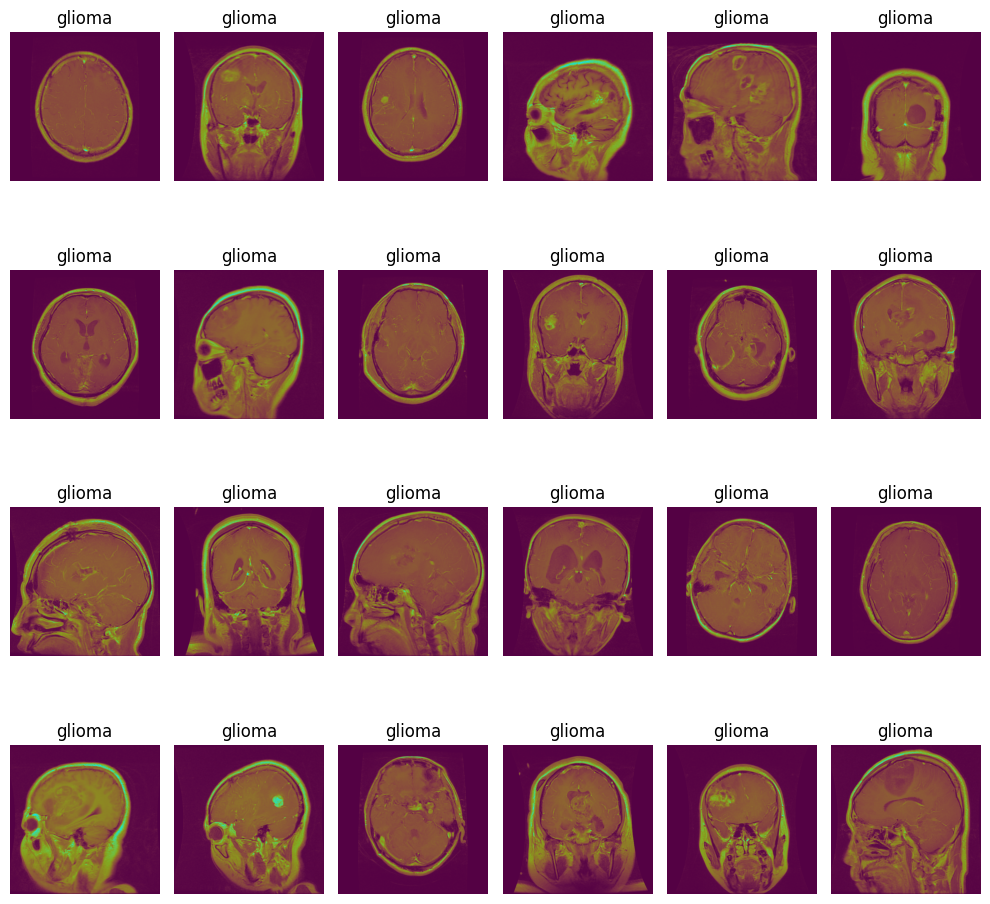

In [6]:
sns.set_palette('viridis')
fig, axs = plt.subplots(4, 6, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(cv2.imread(df.filepaths.values[i]))
    ax.axis('off')
    ax.set_title(df.labels.values[i])
    
plt.tight_layout()
plt.show()

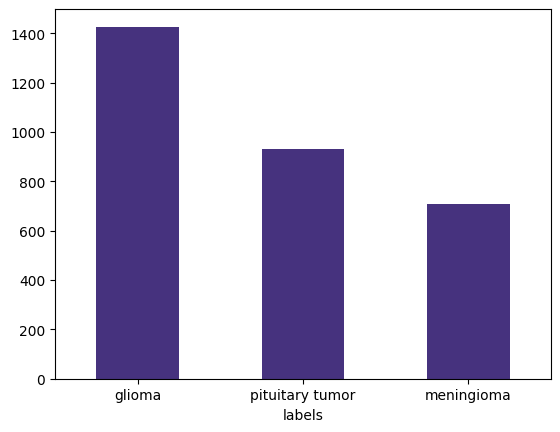

In [7]:
#looking at the distribution of different types of tumor
sns.set_palette('viridis')
df.labels.value_counts().plot(kind='bar', rot=0)
plt.show()

In [8]:
df.labels.value_counts(normalize=True)

labels
glioma             0.465405
pituitary tumor    0.303525
meningioma         0.231070
Name: proportion, dtype: float64

# Data Pre-processing

Following are some of the imperfections that can be there in images captured using MRI:

1. Low resolution
2. Simulation
3. Presence of image artifacts
4. Geometric Distortion
5. Low contrast
6. High level of noise

## Increasing Image Brightness

In [4]:
def increase_bright(img):
    #getting the hue, saturation, and value of the image
    h,s,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    
    #value to increase the brightness by
    value=30

    lim = 255 - value
    #stop overflow
    v[v > lim] = 255
    #increase brightness
    v[v <= lim] += value
    
    #making the final image
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [5]:
#creating a new copy of the dataframe
bright_df = df.copy()

In [6]:
#implementing the function
for _ in df.index:
    bright_df.filepaths.values[_] = cv2.cvtColor(increase_bright(cv2.imread(df.filepaths.values[_])), cv2.COLOR_BGR2GRAY)

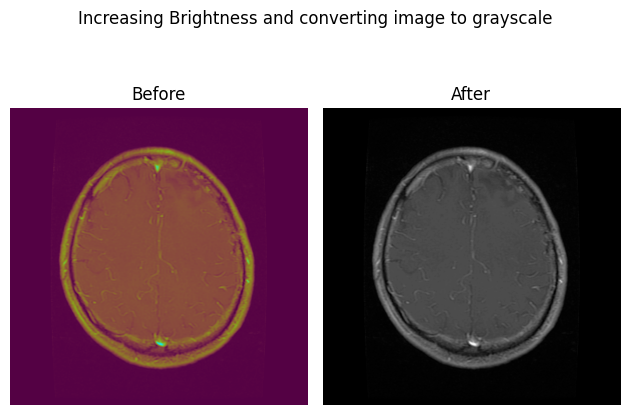

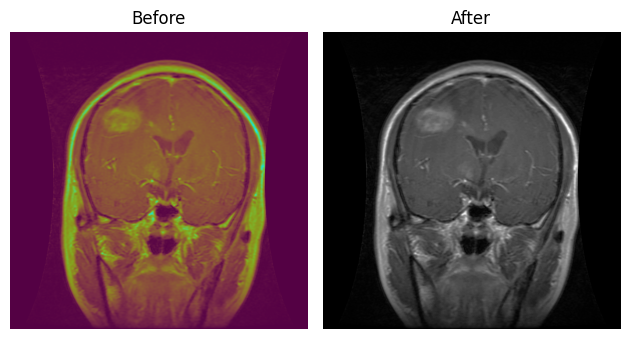

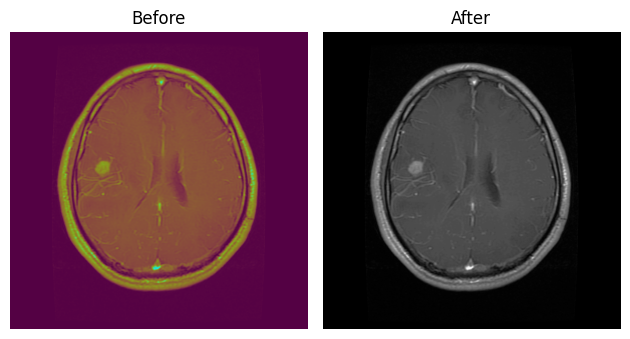

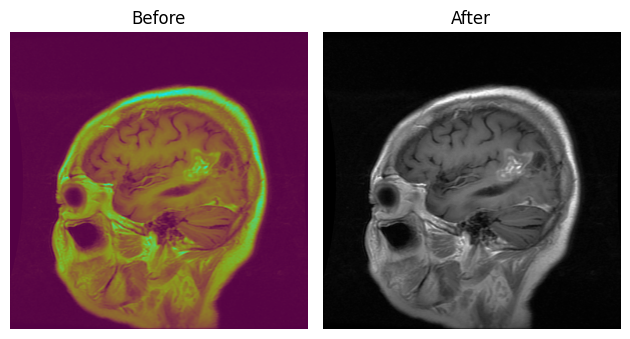

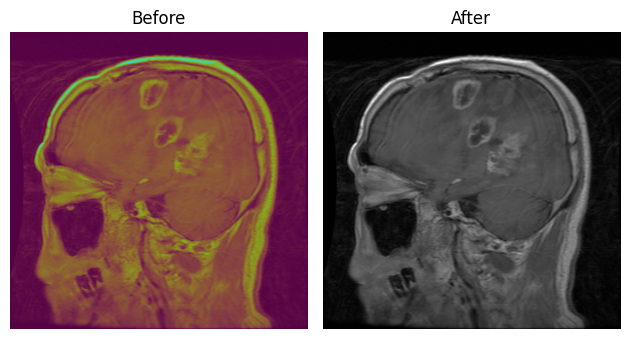

In [12]:
bright_df.rename(columns={'filepaths':'images'}, inplace=True)
for _ in range(5):
    fig, axs = plt.subplots(1, 2)
    axs = axs.flatten()
    axs[0].imshow(cv2.imread(df.filepaths.values[_]))
    axs[0].axis("off")
    axs[0].set_title("Before")
    axs[1].imshow(bright_df.images.values[_], cmap='gray')
    axs[1].axis("off")
    axs[1].set_title("After")
    if _ == 0:
        plt.suptitle("Increasing Brightness and converting image to grayscale")
    plt.tight_layout()
    plt.show()

In [7]:
only_bright_images = bright_df.copy()
only_bright_images.rename(columns={'filepaths':'images'}, inplace=True)

## Applying Otsu Thresholding

In [14]:
for _ in bright_df.index:
    bright_df.images[_] = cv2.threshold(bright_df.images[_], 128, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

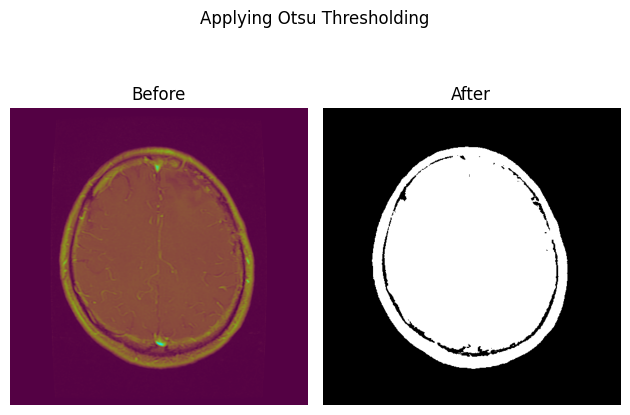

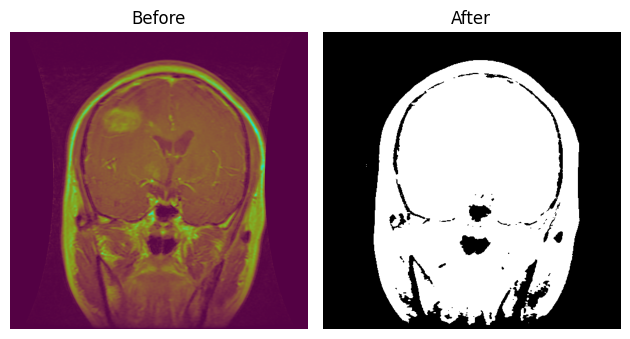

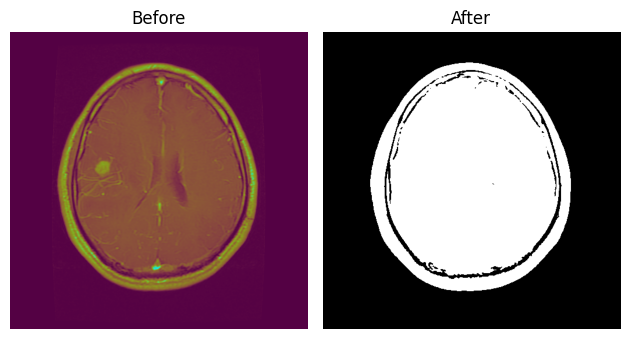

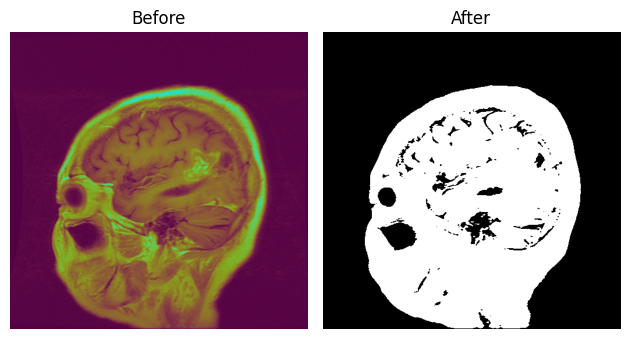

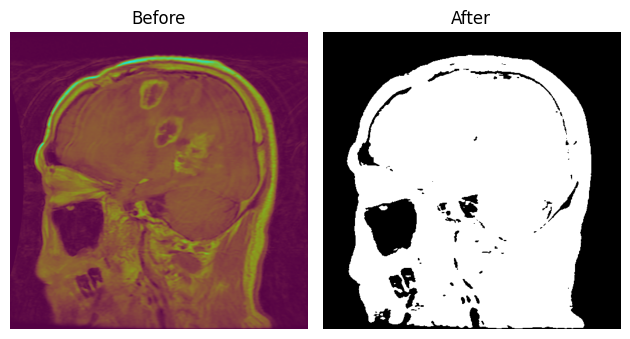

In [15]:
for _ in range(5):
    fig, axs = plt.subplots(1, 2)
    axs = axs.flatten()
    axs[0].imshow(cv2.imread(df.filepaths.values[_]))
    axs[0].axis("off")
    axs[0].set_title("Before")
    axs[1].imshow(bright_df.images.values[_], cmap='gray')
    axs[1].axis("off")
    axs[1].set_title("After")
    if _ == 0:
        plt.suptitle("Applying Otsu Thresholding")
    plt.tight_layout()
    plt.show()

## Filtering

Applying region filling:

In [16]:
#region filling with threshold
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
for _ in bright_df.index:
    bright_df.images[_] = cv2.morphologyEx(bright_df.images[_], cv2.MORPH_OPEN, kernel)

In [8]:
#region filling without threshold
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
for _ in only_bright_images.index:
    only_bright_images.images[_] = cv2.morphologyEx(only_bright_images.images[_], cv2.MORPH_OPEN, kernel)

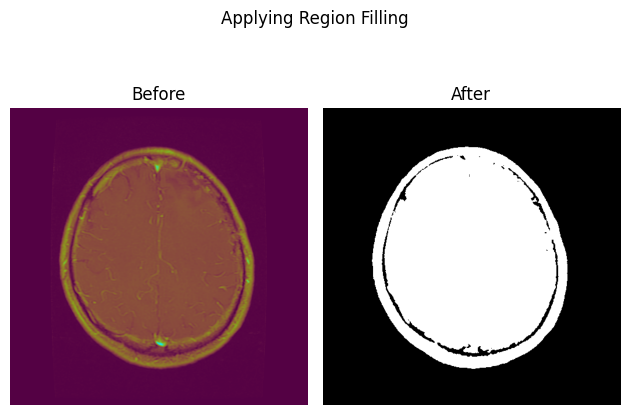

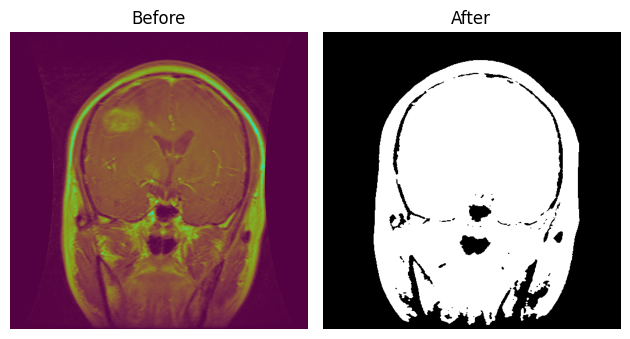

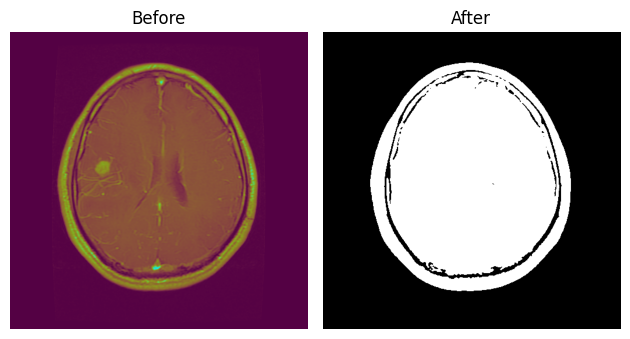

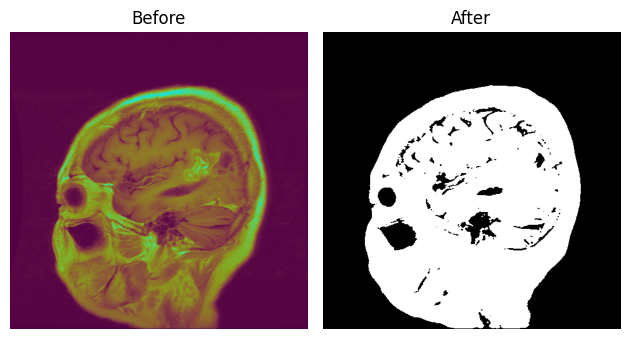

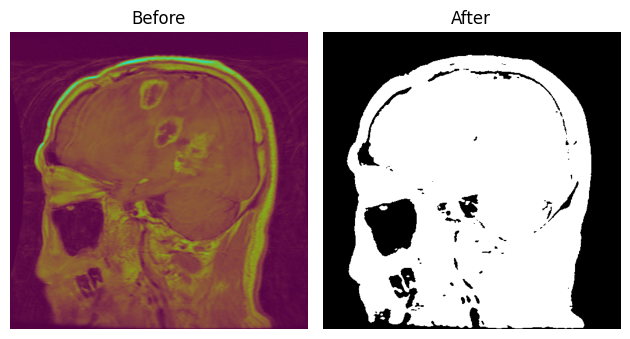

In [18]:
for _ in range(5):
    fig, axs = plt.subplots(1, 2)
    axs = axs.flatten()
    axs[0].imshow(cv2.imread(df.filepaths.values[_]))
    axs[0].axis("off")
    axs[0].set_title("Before")
    axs[1].imshow(bright_df.images.values[_], cmap='gray')
    axs[1].axis("off")
    axs[1].set_title("After")
    if _ == 0:
        plt.suptitle("Applying Region Filling")
    plt.tight_layout()
    plt.show()

## Encoding the target variable and Splitting the dataset

In [19]:
#converting rgb into gray
for _ in bright_df.index:
    bright_df.images[_] = cv2.cvtColor(bright_df.images[_], cv2.COLOR_GRAY2BGR)

In [9]:
#converting rgb into gray (without thresholding)
for _ in only_bright_images.index:
    only_bright_images.images[_] = cv2.cvtColor(only_bright_images.images[_], cv2.COLOR_GRAY2BGR)

In [21]:
#encoding y
X, y = bright_df.images.values, bright_df.labels.values

tumor_types = bright_df.labels.unique()
tumor = dict(zip(tumor_types, [[1, 0, 0], [0, 1, 0], [0, 0, 1]]))

for _ in bright_df.index:
    bright_df.labels[_] = tumor[bright_df.labels[_]]

In [22]:
tumor

{'glioma': [1, 0, 0], 'pituitary tumor': [0, 1, 0], 'meningioma': [0, 0, 1]}

In [23]:
# train dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    test_size= 0.2, 
                                                    shuffle= True, 
                                                    random_state= 42, 
                                                    stratify= y)

# valid and test dataframe
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,  
                                                    test_size= 0.5, 
                                                    shuffle= True, 
                                                    random_state= 42, 
                                                    stratify= y_test)

X_train.shape, X_valid.shape, X_test.shape

((2451,), (306,), (307,))

In [24]:
pd.Series(y_train).value_counts(normalize=True)

[1, 0, 0]    0.465524
[0, 1, 0]    0.303550
[0, 0, 1]    0.230926
Name: proportion, dtype: float64

In [25]:
#indexes to be dropped
drop_idx = []
for _ in range(len(X_train)):
    if X_train[_].shape[0]!=512:
        drop_idx.append(_)
X_train = np.delete(X_train, drop_idx)
y_train = np.delete(y_train, drop_idx)

In [26]:
#drop indexes for the validation set
drop_idx_val = []
for _ in range(len(X_valid)):
    if X_valid[_].shape[0]!=512:
        drop_idx_val.append(_)
X_valid = np.delete(X_valid, drop_idx_val)
y_valid = np.delete(y_valid, drop_idx_val)

In [27]:
#drop indexes for the test set
drop_idx_test = []
for _ in range(len(X_test)):
    if X_test[_].shape[0]!=512:
        drop_idx_test.append(_)
X_test = np.delete(X_test, drop_idx_test)
y_test = np.delete(y_test, drop_idx_test)

In [28]:
#reshaping data
X_train = np.vstack(X_train).reshape(X_train.shape[0], 512, 512, 3)
y_train = np.vstack(y_train)

In [29]:
#reshaping validation set
X_valid = np.vstack(X_valid).reshape(X_valid.shape[0], 512, 512, 3)
y_valid = np.vstack(y_valid)

In [30]:
#reshaping validation set
X_test = np.vstack(X_test).reshape(X_test.shape[0], 512, 512, 3)
y_test = np.vstack(y_test)

In [31]:
X_train.shape, y_train.shape

((2439, 512, 512, 3), (2439, 3))

In [10]:
# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.

base_model = tf.keras.applications.xception.Xception(include_top=False, 
                                                     weights="imagenet",
                                                     input_shape=(512, 512, 3),
                                                     pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 42),
    Dense(3, activation= 'softmax')
])


model.compile(optimizer=keras.optimizers.Adamax(learning_rate= 1e-3), 
              loss= 'categorical_crossentropy', 
              metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,394,987
Trainable params: 21,336,363
Non-trainable params: 58,624
_______________________________________

In [35]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks = [EarlyStopping(monitor='loss', patience=5)],
                    validation_data=(X_valid, y_valid),
                    batch_size=16)

Epoch 1/100
153/153 [==============================] - 144s 695ms/step - loss: 7.5534 - accuracy: 0.7097 - val_loss: 6.9963 - val_accuracy: 0.2993
Epoch 2/100
153/153 [==============================] - 102s 667ms/step - loss: 5.2251 - accuracy: 0.8553 - val_loss: 4.8532 - val_accuracy: 0.7138
Epoch 3/100
153/153 [==============================] - 102s 667ms/step - loss: 3.8888 - accuracy: 0.9143 - val_loss: 3.5005 - val_accuracy: 0.8520
Epoch 4/100
153/153 [==============================] - 100s 655ms/step - loss: 2.8374 - accuracy: 0.9549 - val_loss: 2.6171 - val_accuracy: 0.8816
Epoch 5/100
153/153 [==============================] - 100s 655ms/step - loss: 2.0330 - accuracy: 0.9807 - val_loss: 2.0294 - val_accuracy: 0.8388
Epoch 6/100
153/153 [==============================] - 102s 667ms/step - loss: 1.4381 - accuracy: 0.9869 - val_loss: 1.4541 - val_accuracy: 0.8882
Epoch 7/100
153/153 [==============================] - 100s 655ms/step - loss: 1.0033 - accuracy: 0.9889 - val_loss: 1

In [36]:
#save the weights
model.save_weights('./checkpoints/my_checkpoint')

In [37]:
#save the model
model.save('my_model.keras')

In [48]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 4s 332ms/step - loss: 1.0740 - accuracy: 0.7549


[1.073997974395752, 0.7549019455909729]

### Without thresholding

In [29]:
only_bright_images.images[0]

array([[41, 41, 41, ..., 41, 41, 41],
       [41, 41, 41, ..., 41, 41, 41],
       [41, 41, 41, ..., 41, 41, 41],
       ...,
       [41, 41, 41, ..., 41, 41, 41],
       [41, 41, 41, ..., 41, 41, 41],
       [41, 41, 41, ..., 41, 41, 41]], dtype=uint8)

In [11]:
#encoding y (without thresholding)
X, y = only_bright_images.images.values, only_bright_images.labels.values

tumor_types = only_bright_images.labels.unique()
tumor = dict(zip(tumor_types, [[1, 0, 0], [0, 1, 0], [0, 0, 1]]))

for _ in only_bright_images.index:
    only_bright_images.labels[_] = tumor[only_bright_images.labels[_]]
    
# train dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    test_size= 0.2, 
                                                    shuffle= True, 
                                                    random_state= 42, 
                                                    stratify= y)

# valid and test dataframe
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,  
                                                    test_size= 0.5, 
                                                    shuffle= True, 
                                                    random_state= 42, 
                                                    stratify= y_test)

X_train.shape, X_valid.shape, X_test.shape

pd.Series(y_train).value_counts(normalize=True)

#indexes to be dropped
drop_idx = []
for _ in range(len(X_train)):
    if X_train[_].shape[0]!=512:
        drop_idx.append(_)
X_train = np.delete(X_train, drop_idx)
y_train = np.delete(y_train, drop_idx)

#drop indexes for the validation set
drop_idx_val = []
for _ in range(len(X_valid)):
    if X_valid[_].shape[0]!=512:
        drop_idx_val.append(_)
X_valid = np.delete(X_valid, drop_idx_val)
y_valid = np.delete(y_valid, drop_idx_val)

#drop indexes for the test set
drop_idx_test = []
for _ in range(len(X_test)):
    if X_test[_].shape[0]!=512:
        drop_idx_test.append(_)
X_test = np.delete(X_test, drop_idx_test)
y_test = np.delete(y_test, drop_idx_test)

#reshaping data
X_train = np.vstack(X_train).reshape(X_train.shape[0], 512, 512, 3)
y_train = np.vstack(y_train)

#reshaping validation set
X_valid = np.vstack(X_valid).reshape(X_valid.shape[0], 512, 512, 3)
y_valid = np.vstack(y_valid)

#reshaping validation set
X_test = np.vstack(X_test).reshape(X_test.shape[0], 512, 512, 3)
y_test = np.vstack(y_test)

In [35]:
history_without_thresh = model.fit(X_train, y_train,
                                   epochs=100,
                                   callbacks = [EarlyStopping(monitor='loss', patience=5)],
                                   validation_data=(X_valid, y_valid),
                                   batch_size=16)

Epoch 1/100
153/153 [==============================] - 144s 699ms/step - loss: 6.9710 - accuracy: 0.8212 - val_loss: 7.4210 - val_accuracy: 0.3125
Epoch 2/100
153/153 [==============================] - 102s 669ms/step - loss: 4.5255 - accuracy: 0.9348 - val_loss: 3.8049 - val_accuracy: 0.9079
Epoch 3/100
153/153 [==============================] - 101s 657ms/step - loss: 3.1619 - accuracy: 0.9688 - val_loss: 2.8448 - val_accuracy: 0.8882
Epoch 4/100
153/153 [==============================] - 102s 669ms/step - loss: 2.2212 - accuracy: 0.9844 - val_loss: 1.9256 - val_accuracy: 0.9605
Epoch 5/100
153/153 [==============================] - 101s 657ms/step - loss: 1.5763 - accuracy: 0.9840 - val_loss: 1.4119 - val_accuracy: 0.9309
Epoch 6/100
153/153 [==============================] - 102s 669ms/step - loss: 1.1025 - accuracy: 0.9914 - val_loss: 0.9264 - val_accuracy: 0.9836
Epoch 7/100
153/153 [==============================] - 102s 669ms/step - loss: 0.7670 - accuracy: 0.9938 - val_loss: 0

In [25]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 15s 537ms/step - loss: 0.1712 - accuracy: 0.9641


[0.17124338448047638, 0.9640522599220276]

In [30]:
model.load_weights('/kaggle/input/weights/model_weights.h5')

In [36]:
#save the model
model.save('bright_region_filling.keras')

## Looking at the predictions

In [25]:
y_test_new = []

for _ in range(len(y_test)):
    if y_test[_][0] == 1:
        y_test_new.append(0)
    elif y_test[_][1] == 1:
        y_test_new.append(1)
    elif y_test[_][2] == 1:
        y_test_new.append(2)

10/10 [==============================] - 3s 344ms/step


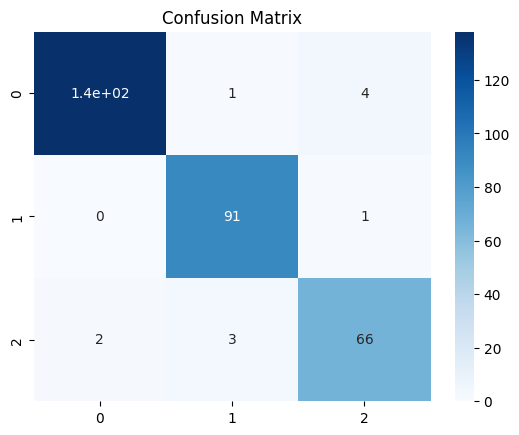

In [36]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
sns.set_palette('Blues')
sns.heatmap(confusion_matrix(y_test_new, y_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [40]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       143
           1       0.96      0.99      0.97        92
           2       0.93      0.93      0.93        71

    accuracy                           0.96       306
   macro avg       0.96      0.96      0.96       306
weighted avg       0.96      0.96      0.96       306



In [43]:
from sklearn.metrics import fbeta_score

fbeta_score(y_test_new, y_pred, beta=0, average='weighted')

0.9643250282569167

# END